In [73]:
#####set up the environment
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as stats
from scipy.stats import chi2
from lxml.html import parse
from urllib.request import urlopen
from os.path import getsize
from math import log
from __future__ import division
from pandas import Series, DataFrame
import urllib 
import statsmodels.api as sm
import statsmodels.tsa
from statsmodels.tsa.stattools import q_stat, acf, pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from statsmodels.tsa.stattools import pacf
import statsmodels.formula.api as sm
from statsmodels.tsa.tsatools import  lagmat
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_process import arma_generate_sample
%matplotlib inline
import os
import sys
import matplotlib  
from matplotlib.pyplot import plot,savefig 
from numpy.random import randn
import matplotlib.pyplot as plt


In [74]:
%pwd

'/Users/wrk/Documents/notebook0'

1.38320834519
1.5585688538
1.69581105794
2.14270029696
2.17244481326


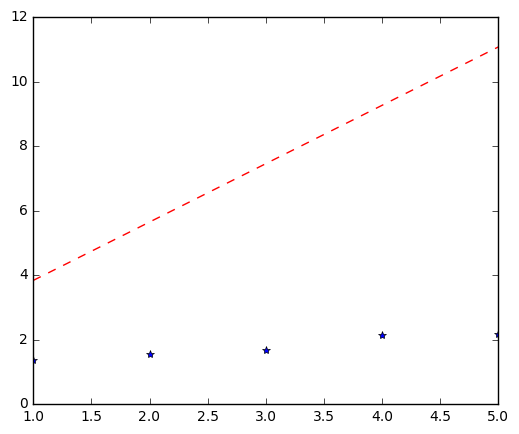

In [75]:
def autocoef(data,k):
    meanw=np.mean(data)
    n=len(data)    
    return np.nansum((data[:(n-k)]-meanw)*(data[k:]-meanw))/np.nansum((data-meanw)**2)
def qtest(data,m,plot):
    q=np.zeros(m)
    l=[(autocoef(data,i+1))**2 for i in range(m)]
    for j in range(m):
        q[j]=sum(l[:j+1])*len(data)
        print(q[j])
    if plot==1:
        plt.figure(figsize=(6,5))
        plt.plot(range(1,m+1),q[:],"b*",[1,m],stats.chi2.ppf(0.95,[1,m]),"r--")
n=1000
data=np.random.normal(size=n)
qtest(data,5,1)

+ (a)

$${r_t} = {\phi _0} + {\phi _1}{r_{t - 1}} + {\phi _2}{r_{t - 2}} + {a_t}$$
对上式两边求期望得： 
$$E\left( {{r_t}} \right) = \frac{{{\phi _0}}}{{1 - {\phi _1} - {\phi _2}}}$$
考虑零均值的二阶自回归模型 $${r_t} ={\phi _1}{r_{t - 1}} + {\phi _2}{r_{t - 2}} + {a_t}$$
显然$${\rho _0} = 1$$
在${r_t} ={\phi _1}{r_{t - 1}} + {\phi _2}{r_{t - 2}} + {a_t}$两边同时乘上${r_{t - 1}}$得：
$${r_t}{r_{t - 1}} ={\phi _1}{r_{t - 1}}{r_{t - 1}} + {\phi _2}{r_{t - 2}}{r_{t - 1}} + {a_t}{r_{t - 1}}$$
对上式两边同时求期望得${\rho _1}={\phi _1}+{\phi _2}{\rho _1}$
即：$${\rho _1} = \frac{{{\phi _1}}}{{1 - {\phi _2}}}$$
再对原式两边同时乘上${r_{t - l}}$得：
$${r_t}{r_{t - l}} ={\phi _1}{r_{t - 1}}{r_{t - l}} + {\phi _2}{r_{t - 2}}{r_{t - l}} + {a_t}{r_{t - l}}$$
对上式两边同时求期望得$${\rho _l} = {\phi _1}{\rho _{l - 1}} + {\phi _2}{\rho _{l - 2}},\;\;\;{\kern 1pt} l \ge 1$$

证毕

In [76]:
##stable or not
def stable(phi1,phi2):
    if (phi1**2+4*phi2)>0:
        a=np.abs((-phi1+np.sqrt(phi1**2+4*phi2))/(2*phi2))
        b=np.abs((-phi1-np.sqrt(phi1**2+4*phi2))/(2*phi2))
        if a>1 and b>1:
            print('stable')
        else:
            print('not stable')
    else:
        if -1/phi2>1:
             print('stable')
        else:
            print('not stable')

In [77]:
###autocorralation
def autocorr(phi1,phi2,p):
    y=1;z=phi1/(1-phi2)
    x=[y,z]
    for i in range(2,p+1):
        t=phi1*z+phi2*y
        x.append(t)
        y=z;z=t
    return x

In [78]:
###get sina stock
def get_sina_stock(stockid,start="1990-12-19",end=pd.datetime.now(),isstock=True,fuquan=True):    
    def _unpack(row, kind='td'):
        elts = row.findall('.//%s' % kind)
        return [val.text_content().strip() for val in elts] 
    def parse_options_data(table,isstock,fuquan):
        rows = table.findall('.//tr')
        data = [_unpack(r) for r in rows[2:]]
        if isstock & fuquan:
            colnames = ['date','open','high','close','low','vol','amount','ratio'] 
        else:
            colnames = ['date','open','high','close','low','vol','amount']
        data= pd.DataFrame(data,columns=colnames)
        data.index=pd.to_datetime(data["date"])
        data=data.drop("date",axis=1)
        data=data.ix[range(len(data)-1,-1,-1)]
        return  data
    data=pd.DataFrame()
    daterange=pd.date_range(start,end,freq="Q")
    daterange=daterange.insert(len(daterange),daterange[-1]+1)
    for cq in daterange: 
        if isstock:
            if fuquan:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_FuQuanMarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
            else:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)            
        else:            
            url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'/type/S.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
        try:
            parsed = parse(urlopen(url))
        except:
            print ("download failed for year=" +str(cq.year)+',  jidu='+str(cq.month/3))
            continue
        doc = parsed.getroot()
        tables=doc.findall('.//table')     
        da= tables[-1] # last table 19 for fuquan data and 4 for index
        datatem = parse_options_data(da,isstock,fuquan)
        data=pd.concat([data,datatem])
    return pd.DataFrame(data[start:end],dtype=float)    

0.00683450194434
0.726538294956
2.7432222176
2.89114728364
6.822616157


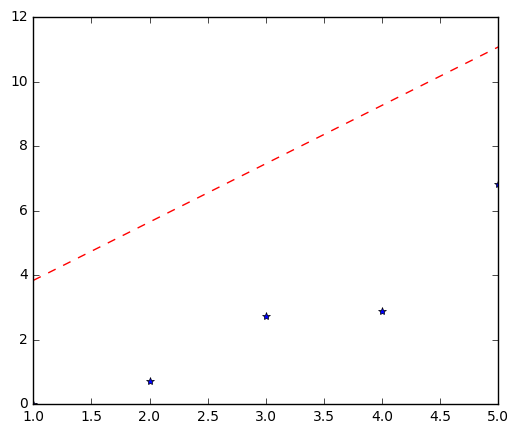

In [87]:
data=get_sina_stock(600376,"2012-1-1","2016-12-1")
SimpleReturnDaily1=data["close"].pct_change()
SimpleReturnDaily1=SimpleReturnDaily1.dropna()
SimpleReturnDaily1=list(SimpleReturnDaily1)
qtest(SimpleReturnDaily1,5,1)

In [88]:
#95%的阀值为：
from scipy.linalg import toeplitz
print(1.96/np.sqrt(len(SimpleReturnDaily1)))
def mypacf(ac,k):    
    r=ac[:k]
    R = toeplitz(r[:-1])
    rho = np.linalg.solve(R, r[1:])
    return(rho)
print(mypacf(SimpleReturnDaily1,10))
print(mypacf(SimpleReturnDaily1,11))
print(mypacf(SimpleReturnDaily1,12))

0.0572278019224
[ 0.05771662 -0.22397335  0.99959908 -0.61096249  0.20538664  0.1116322
 -0.92493255 -0.02216051 -1.05254003]
[-0.86091933 -0.2433146   0.1923364  -0.51353213  0.384644   -0.42160367
 -0.05250242 -0.21763998 -1.00216612 -0.87278005]
[-4.04987315 -3.90501777 -0.6028741  -0.70536486 -1.15580669  0.9838042
 -1.92884026  0.48511656 -1.89118625 -4.01839729 -3.65378862]


In [89]:
# 最小二乘估计
import statsmodels.formula.api as sm
# 自回归的数据矩阵　
from statsmodels.tsa.tsatools import  lagmat
A=lagmat(SimpleReturnDaily1,11)
results = sm.OLS(SimpleReturnDaily1, A).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.444
Date:                Sat, 31 Dec 2016   Prob (F-statistic):            0.00513
Time:                        15:26:11   Log-Likelihood:                 2421.4
No. Observations:                1173   AIC:                            -4821.
Df Residuals:                    1162   BIC:                            -4765.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0003      0.029     -0.012      0.9

23.8074658837
28.6156720642
29.3387452961
30.1091573032
33.8834471474


array([ 1.        ,  0.62982892, -0.18053684,  0.02266526,  0.13172511,
        0.2406439 ,  0.1042829 ,  0.02685878, -0.1058745 ,  0.14390792,
        0.04443043])

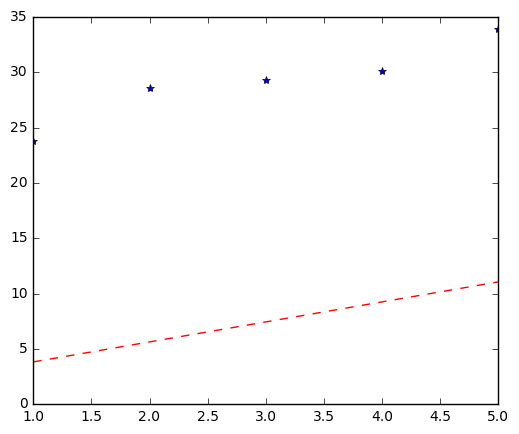

In [90]:
A1 = pd.read_table("gdp.csv",sep=",")
SimpleReturnDaily=A1["gdp"].pct_change()
SimpleReturnDaily=SimpleReturnDaily.dropna()
SimpleReturnDaily=list(SimpleReturnDaily)
qtest(SimpleReturnDaily,5,1)
pacf(SimpleReturnDaily,10)

In [91]:
#####最小二乘估计 
X=lagmat(SimpleReturnDaily,2)
results = sm.OLS(SimpleReturnDaily, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     66.28
Date:                Sat, 31 Dec 2016   Prob (F-statistic):           6.41e-16
Time:                        15:26:20   Log-Likelihood:                 71.495
No. Observations:                  62   AIC:                            -139.0
Df Residuals:                      60   BIC:                            -134.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.8269      0.129      6.405      0.0

In [92]:
print('Variance:'+str(results.resid.std()))
print('Expectation：'+str(results.resid.mean()))

Variance:0.0740957701148
Expectation：0.018521792595


In [93]:
phi1=0.8269;phi2=0.006
2*np.pi/np.arccos(phi1/(2*np.sqrt(-phi2)))

nan

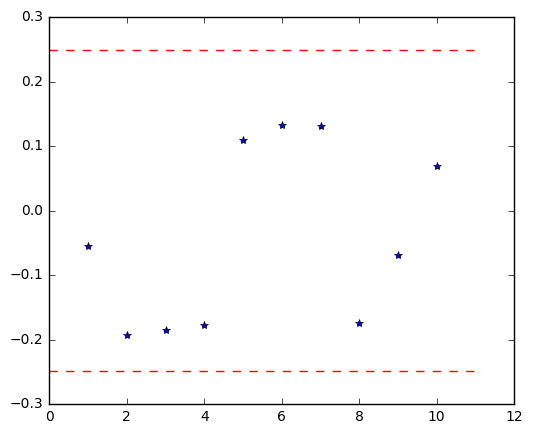

In [94]:
###可以看出，无周期
k=10
autoco=[autocoef(results.resid,i) for i in range(k+1)]
n=len(results.resid)
plt.figure(figsize=(6,5))
plt.plot(range(1,k+1),autoco[1:],"b*",[0,k+1],[1.96/np.sqrt(n)]*2,"r--",[0,k+1],[-1.96/np.sqrt(n)]*2,"r--")

In [95]:
n=len(SimpleReturnDaily)
x1=SimpleReturnDaily[n-2]
x2=SimpleReturnDaily[n-1]

In [96]:
sig=results.resid.std()
a=results.predict(exog=[x1,x2])
print('2015 prediction：'+str(a))
print('%95 confidence interval：'+str(a-1.96*sig)+'-'+str(a+1.96*sig))

2015 prediction：[ 0.07941253]
%95 confidence interval：[-0.06581518]-[ 0.22464024]


In [97]:
b=results.predict(exog=[x2,a])
print('2016 prediction：'+str(b))
print('%95 confidence interval：'+str(b-1.96*sig)+'-'+str(b+1.96*sig))

2016 prediction：[ 0.06363451]
%95 confidence interval：[-0.0815932]-[ 0.20886222]


283.463128679
563.372684874
839.680599623
1112.49484359
1382.26701977
1649.2048779


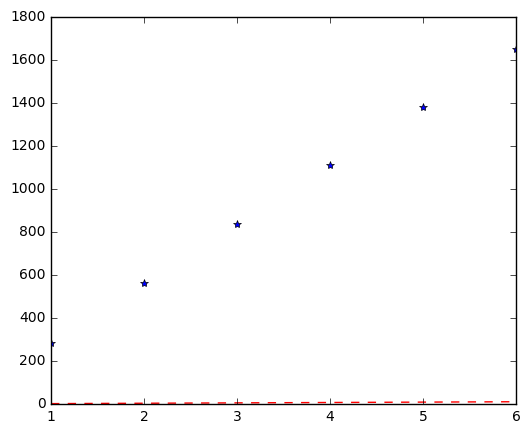

In [102]:
data=get_sina_stock("000001","1991-1-1","2014-12-31",isstock=False)
data_month_high=data['high'].resample("M").mean()
data_month_low=data['low'].resample("M").mean()
data_month_high_log=data_month_high.map(log)
data_month_low_log=data_month_low.map(log)
data_month_variance=data_month_high_log-data_month_low_log
data_month_variance
log(len(data_month_variance))
qtest(data_month_variance,6,1)
###Q值>>卡方分布的95%分位点，拒绝白噪声假设

count    287.000000
mean       0.000105
std        0.012667
min       -0.095757
25%       -0.003221
50%        0.000012
75%        0.003761
max        0.108143
dtype: float64
0.115695141876


array([ 1.        , -0.39979156, -0.30594176, -0.08545339, -0.07591949,
       -0.18000932,  0.01770382,  0.06744801, -0.05291108, -0.03858413,
        0.05268082])

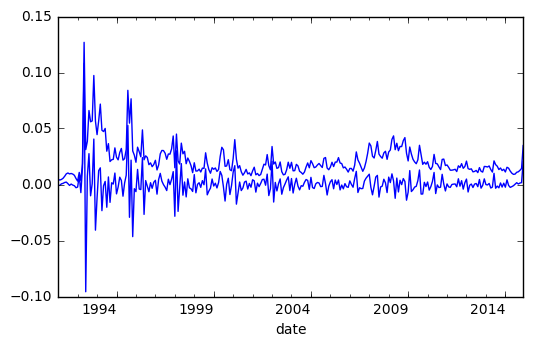

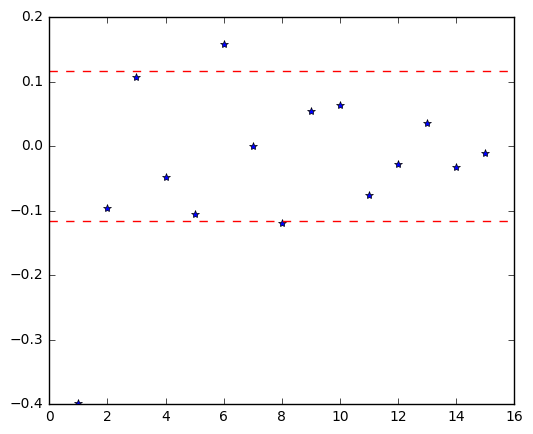

In [99]:
data_month_variance.plot(subplots=True)
data_month_variance=data_month_variance-data_month_variance.shift(1)
data_month_variance.plot(subplots=True)
data_month_variance=data_month_variance.dropna()
adfuller(data_month_variance)
print(data_month_variance.describe())
acf(data_month_variance,nlags=15)
k=15
autoco=acf(data_month_variance,nlags=k)
n=len(data_month_variance)
plt.figure(figsize=(6,5))
plt.plot(range(1,k+1),autoco[1:],"b*",[0,k+1],[1.96/np.sqrt(n)]*2,"r--",[0,k+1],[-1.96/np.sqrt(n)]*2,"r--")
acf(data_month_variance,nlags=15)
print(1.96/np.sqrt(len(data_month_variance)))
pacf(data_month_variance,10)

In [101]:
##由上知MA模型的阶取8,AR模型的阶取5
statsmodels.formula.api??
mean=data_month_variance.mean()
data_month_variance=data_month_variance-mean
res = sm.tsa.arma_order_select_ic(data_month_variance, ic=['aic','bic'], trend='nc')
print(res.aic_min_order,res.bic_min_order)
print(res.aic)
print(res.bic)

AttributeError: module 'statsmodels.formula.api' has no attribute 'tsa'

In [103]:
arma_mod1 = sm.tsa.ARIMA(data_month_variance,order=(0,1,1))
arma_res = arma_mod1.fit(trend='nc')
arma_res.summary2()

AttributeError: module 'statsmodels.formula.api' has no attribute 'tsa'

拟合出来的模型为：$${r_t} = {r_{t - 1}} + {\varepsilon _t} + {\varepsilon _{t - 1}}$$

In [107]:
##残差的方差为
arma_res.resid.std()
a=pd.date_range('1/1/1991','31/12/2014',freq='M')
index=list(a)
num=list(a)
for i in range(len(index)):
    x=list(str(index[i]))
    x=x[:7]
    index[i]=''.join(x)
for i in range(len(index)):
    num[i]=len(data[index[i]])
num=num[:len(num)-1]
num

X = sm.add_constant(num, prepend=False)
results2 = sm.OLS(data_month_variance, X).fit()
results2.summary() 
plt.plot(acf(results2.resid.values) )
q_stat(results2.resid,len(results2.resid))
resi=results2.resid
resi=resi.dropna()
plt.plot(acf(resi),"*",[2/np.sqrt(len(resi))]*40,"r-",[-2/np.sqrt(len(resi))]*40,"r-")
print (2/np.sqrt(len(resi)))
es = sm.tsa.arma_order_select_ic(resi, ic=['aic', 'bic'], trend='nc')
print (es.aic_min_order,es.bic_min_order)
print (es.aic)
print (es.bic)

AttributeError: module 'statsmodels.formula.api' has no attribute 'add_constant'

In [ ]:
arma_mod1 = sm.tsa.ARIMA(data_month_variance,order=(3,1,1),exog=X)
arma_res = arma_mod1.fit(trend='nc')
arma_res.summary2()
plt.plot(acf(arma_res.resid),"*",[2/np.sqrt(len(resi))]*40,"r-",[-2/np.sqrt(len(resi))]*40,"r-")

In [ ]:
##d应该取2
##第一个acf图说明这个时间序列有线性趋势项，
##第二个acf图说明一阶差分后的序列是一个白噪声序列，
##第三个acf图说明二阶差分后的时间序列可以用6阶MA模型进行拟合。

In [ ]:
y=[0,0,0,0]
e=[0,0]
sigma=[0,0]
y[0]=120.1
y[1]=118.3
e[0]=-2.3
e[1]=2.6
y[2]=103+0.2*y[1]+0.4*e[1]-0.25*e[0]
y[3]=103+0.2*y[2]-0.25*e[1]
sigma[0]=1
sigma[1]=1+0.2**2+0.25**2
print(y[2],y[3])
print([[y[2]-1.96*sigma[0],y[2]+1.96*sigma[0]],[y[3]-1.96*sigma[1],y[3]+1.96*sigma[1]]])